## Grid World

Here's the gridworld example (Example 4.1 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf)). 

- State 0 and 15 are the terminal states.
- Agent is allowed to move UP, RIGHT, DOWN and LEFT.
- Each action deterministically cause the state transitions, except that actions which would take our agent off the grid, in such case the state remains unchanged.
- Reward of -1 on all transitions.
- Undiscounted and episodic.

We will solve this problem i.e. find the optimal oplicy using policy iterations

![title](images/M3A1-P1.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
class grid_world_environment(object):
    def __init__(self, n_row : int = 4, n_col : int = 4) -> None:
        '''
        @paramenters
        n_row  : Number of rows in the grid
        n_col  : Number of columns in the grid
        
        @doc
        Initializes the gridword of size (n_row, n_col)
        '''
        self.n_row = n_row
        self.n_col = n_col
        self.n_states = self.n_row * self.n_col
        self.n_actions = 4
        self.states = np.arange(self.n_states)
        self.actions = np.arange(self.n_actions) #0:up , 1:right, 2:down, 3:left
        self.terminal_states = [0,self.n_states-1]
        self.non_terminal_states = list(set(self.states) - set(self.terminal_states))
           
    def p(self, s :int, a : int, s_dash : int) -> None:
        '''
        @parameters
        s       : current state
        a       : action taken
        s_dash  : prospective next state
        
        @doc
        Returns the probbaility of transitioning to state 's_dash', if agent takes action 'a' in state 's' 
        '''
        assert a in self.actions
        if(a == 0): #Move up
            if(s - self.n_col < 0 and s_dash == s):
                return 1 
            elif(s_dash == s - self.n_col):
                return 1
            else:
                return 0
        
        if(a == 1): #Move right
            if((s + 1)%self.n_col == 0 and s_dash == s):
                return 1
            elif((s + 1)%self.n_col != 0 and s_dash == s + 1):
                return 1
            else:
                return 0
            
        if(a == 2): #Move down
            if(s + self.n_col >= self.n_states and s_dash == s):
                return 1
            elif(s_dash == s + self.n_col):
                return 1
            else:
                return 0
        
        if(a == 3): #Move left
            if(s%self.n_col == 0 and s_dash == s):
                return 1
            elif(s%self.n_col != 0 and s_dash == s - 1):
                return 1
            else:
                return 0
    
    def reward(self, s_dash : int) -> float:
        '''
        @parameter
        s_dash    : The state agent is transitioning into
        
        @doc
        Return the reward if agent transtions to state 's_dash'
        '''
        return -1

## Policy Evaluation

<img src="images/M3A1-P2.png" alt="M4A1-P3" width="500"/>

## Policy Iteration

<img src="images/M3A1-P3.png" alt="M4A1-P3" width="500"/>

In [7]:
class agent(object):
    def __init__(self, env : grid_world_environment, gamma : float = 1.0, theta : float = 0.001) -> None:
        '''
        Initializing the agent properties like value function, gamma, theta and the policy. 
        Initial policy is an equiprobable policy.
        '''
        self.V = np.zeros((env.n_states))
        self.gamma = gamma
        self.policy = {}
        self.theta = theta
        self.env = env
        for state in env.non_terminal_states:
            for action in env.actions:
                self.policy[(state,action)] = 0.25
    
    def policy_evaluation(self, n_iter : int = 1000) -> None:
        '''
        In place policy evaluation. Tries to find the tru value function within 'n_iter' number of iterations.
        '''
        for it in range(n_iter):
            delta = 0
            for state in self.env.non_terminal_states:
                value = 0
                for action in self.env.actions:
                    for state_dash in self.env.states:
                        value += (self.policy[(state,action)] * \
                                          self.env.p(state,action,state_dash) * \
                                          (self.env.reward(state_dash) + self.gamma * self.V[state_dash]))
                delta = max(delta,np.abs(self.V[state] - value))
                self.V[state] = value
            if(delta < self.theta):
                print("Policy converged to true state values after {} iterations".format(it+1))
                self.plot_value()
                return
        print("Policy did not converge to true state value functions.")
        print(self.V)
    
    def policy_improvement(self) -> bool:
        '''
        Policy improvement algorithm. The policy is imporved by acting greedily with repspect to the current value function.
        If two actions gives same value, then equal probability is assigned to both of the actions.
        Returns True if current policy is same as previous poliy, that is the current policy is the optimal policy. 
        Else it return false.
        '''
        policy_stable = False
        new_policy = {}
        for state in self.env.non_terminal_states:
            best_actions = list()
            best_value = float("-inf")
            for action in self.env.actions:
                value = 0
                for state_dash in self.env.states:
                    value += (self.env.p(state,action,state_dash)*\
                              (self.env.reward(state_dash) + self.gamma * self.V[state_dash]))
                if(value == best_value):
                    best_actions.append(action)
                elif(value > best_value):
                    best_value = value
                    best_actions = [action]
            for action in self.env.actions:
                if(action in best_actions):
                    new_policy[(state,action)] = 1.0/len(best_actions)
                else:
                    new_policy[(state,action)] = 0
        if(new_policy == self.policy):
            policy_stable = True
        self.policy = dict(new_policy.items())
        return policy_stable
    
    def policy_iteration(self, n_policy_iter :int = 100, n_policy_eval_iter : int = 1000) -> None:
        '''
        Policy iteration algorithm. It calls the policy evaluation step and policy improvement step alternately for a max
        of 'n_policy_iter' iterations. 
        '''
        for it in range(n_policy_iter):
            self.policy_evaluation(n_policy_eval_iter)
            policy_stable = self.policy_improvement()
            if(policy_stable):
                print("Optimal policy found after {} iterations".format(it+1))
                return
        print("Could not find optimal policy.")
    
    def plot_value(self) -> None:
        '''
        Plots the value functions of the sates in the grid.
        '''
        fig, ax = plt.subplots()
        grid_value = np.reshape(self.V , (self.env.n_row, self.env.n_col))
        for i in range(self.env.n_col):
            for j in range(self.env.n_row):
                c = grid_value[j][i]
                ax.text(i+0.5, j+0.5, str(round(c,1)), va='center', ha='center')  
        ax.set_xlim(0, self.env.n_col)
        ax.set_ylim(self.env.n_row, 0)
        ax.set_xticks(np.arange(self.env.n_col))
        ax.set_yticks(np.arange(self.env.n_row))
        ax.grid()
        plt.show()

Policy converged to true state values after 88 iterations


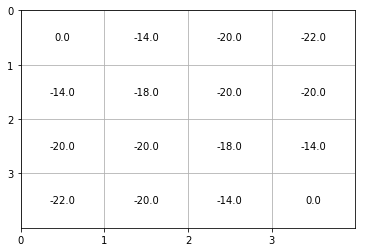

In [8]:
env = grid_world_environment(4,4)
ag = agent(env)
ag.policy_evaluation()

Policy converged to true state values after 88 iterations


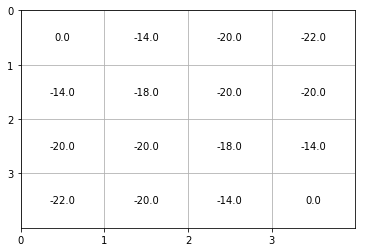

Policy converged to true state values after 3 iterations


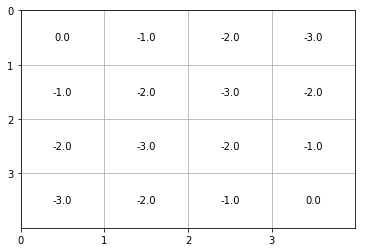

Policy converged to true state values after 1 iterations


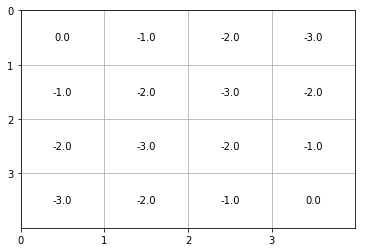

Optimal policy found after 3 iterations


In [10]:
env = grid_world_environment(4,4)
ag = agent(env)
ag.policy_iteration()